# FNN


In [9]:
# @title Lendo a planilha

import numpy as np
import pandas as pd

df = pd.read_csv("dados.csv", index_col=0)

ciclos = df.index.values
t_feed = df["t_feed"].values
t_rinse = df["t_rinse"].values
t_blow = df["t_blow"].values
t_purge = df["t_purge"].values

purity_H2 = df["purity_H2"].values
H2_CO_ratio = df["H2_CO_ratio"].values
purity_CO2 = df["purity_CO2"].values
recovery_CO2 = df["recovery_CO2"].values
productivity = df["productivity"].values


In [10]:
y = np.array(
    [
        purity_H2,
        H2_CO_ratio,
        purity_CO2,
        recovery_CO2,
        productivity,
    ]
).T
u = np.array([t_feed, t_rinse, t_blow, t_purge]).T


In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# -----------------------------
# Preparação dos dados
# -----------------------------

# Constrói o vetor de regressão como no ARX
phi = np.hstack([y[:-1], u[:-1]])  # entrada
target = y[1:]  # saída

# Converte para tensores
X = torch.tensor(phi, dtype=torch.float32)
Y = torch.tensor(target, dtype=torch.float32)

N, input_dim = X.shape
_, output_dim = Y.shape

# -----------------------------
# Rede Neural (MLP simples)
# -----------------------------


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, output_dim),
        )

    def forward(self, x):
        return self.net(x)


model = MLP(input_dim, output_dim)

# -----------------------------
# Treinamento
# -----------------------------

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

epochs = 5000

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, Y)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss = {loss.item():.6f}")

# -----------------------------
# Simulação autoregressiva
# -----------------------------

y_nn = np.zeros_like(y)
y_nn[0] = y[0]  # inicializa com o primeiro valor

model.eval()

for k in range(1, len(y)):
    phi_k = np.concatenate([y_nn[k - 1], u[k - 1]])
    phi_k = torch.tensor(phi_k, dtype=torch.float32)
    y_nn[k] = model(phi_k).detach().numpy()

y_nn = y_nn


Epoch 0 | Loss = 4315.139648
Epoch 200 | Loss = 2941.266357
Epoch 400 | Loss = 2031.672241
Epoch 600 | Loss = 1366.711914
Epoch 800 | Loss = 890.185242
Epoch 1000 | Loss = 559.233948
Epoch 1200 | Loss = 337.770966
Epoch 1400 | Loss = 195.623077
Epoch 1600 | Loss = 108.474022
Epoch 1800 | Loss = 57.672340
Epoch 2000 | Loss = 29.672993
Epoch 2200 | Loss = 15.184358
Epoch 2400 | Loss = 8.204272
Epoch 2600 | Loss = 5.103478
Epoch 2800 | Loss = 3.846755
Epoch 3000 | Loss = 3.387408
Epoch 3200 | Loss = 3.237899
Epoch 3400 | Loss = 3.195172
Epoch 3600 | Loss = 3.184617
Epoch 3800 | Loss = 3.182402
Epoch 4000 | Loss = 3.182014
Epoch 4200 | Loss = 3.181960
Epoch 4400 | Loss = 3.181954
Epoch 4600 | Loss = 3.181953
Epoch 4800 | Loss = 3.181953


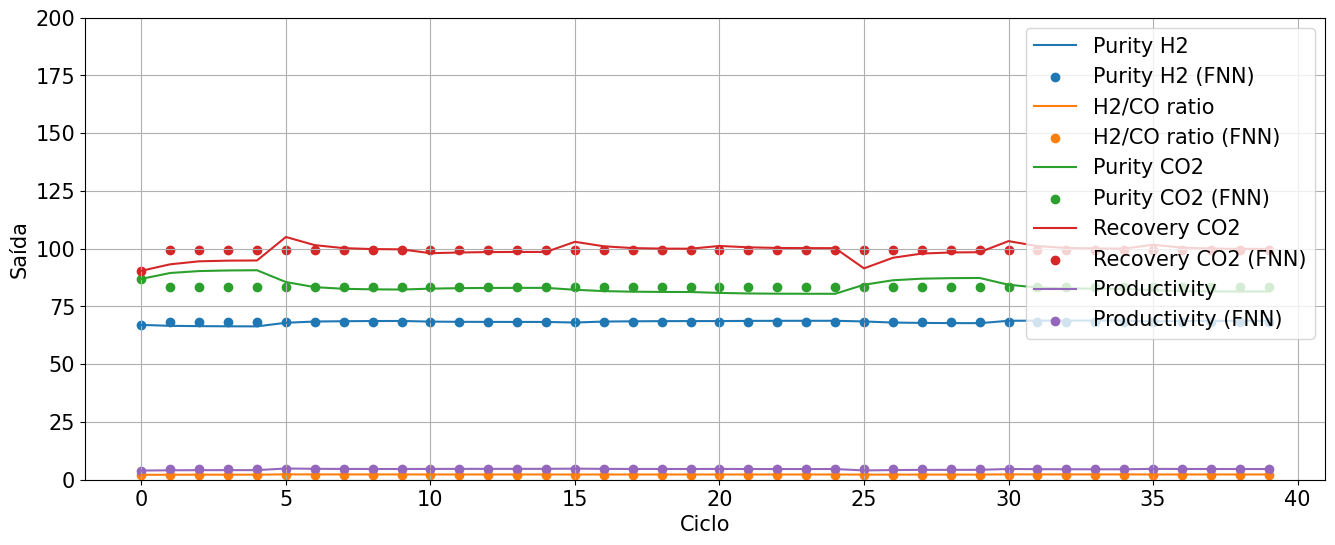

In [12]:
# Plotando resultados
from lib.plot import plt

plt.figure()

plt.plot(ciclos, y[:, 0], label="Purity H2")
plt.scatter(ciclos, y_nn[:, 0], label="Purity H2 (FNN)")

plt.plot(ciclos, y[:, 1], label="H2/CO ratio")
plt.scatter(ciclos, y_nn[:, 1], label="H2/CO ratio (FNN)")

plt.plot(ciclos, y[:, 2], label="Purity CO2")
plt.scatter(ciclos, y_nn[:, 2], label="Purity CO2 (FNN)")

plt.plot(ciclos, y[:, 3], label="Recovery CO2")
plt.scatter(ciclos, y_nn[:, 3], label="Recovery CO2 (FNN)")

plt.plot(ciclos, y[:, 4], label="Productivity")
plt.scatter(ciclos, y_nn[:, 4], label="Productivity (FNN)")

plt.ylim(0, 200)

plt.xlabel("Ciclo")
plt.ylabel("Saída")
plt.legend()
plt.grid(True)
plt.show()
